In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [ ]:
def pad_and_resize(img, target_size):
    old_size = img.size
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, image.ANTIALIAS)
    new_img = image.new("RGB", (target_size, target_size))
    new_img.paste(img, ((target_size - new_size[0]) // 2, (target_size - new_size[1]) // 2))
    return new_img

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, target_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.target_size = target_size

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = []
        batch_y = []
        for i, j in enumerate(index_array):
            img_path = self.filepaths[j]
            img = image.load_img(img_path)
            img = pad_and_resize(img, self.target_size[0])
            img = image.img_to_array(img)
            img = self.random_transform(img)
            img = self.standardize(img)
            batch_x.append(img)
            batch_y.append(self.labels[j])
        return np.array(batch_x), np.array(batch_y)

data_dir = '../images/'

img_height, img_width = 256, 256

train_datagen = CustomImageDataGenerator(
    target_size=(img_height, img_width),
    rescale=1./255,
    validation_split=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 11009 images belonging to 82 classes.
Found 2718 images belonging to 82 classes.


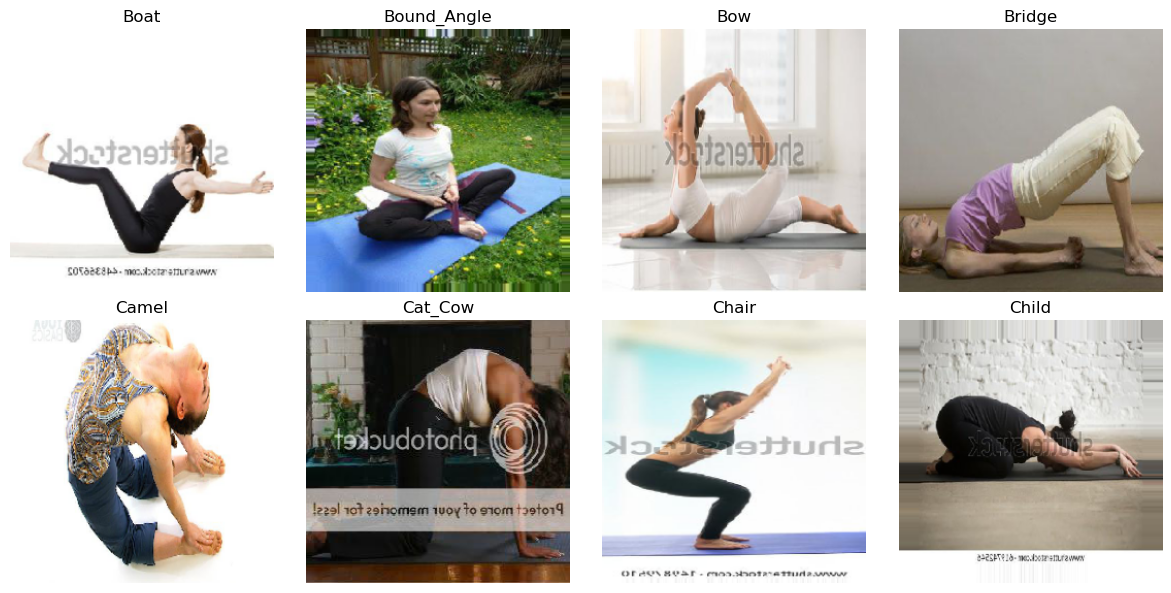

In [ ]:
def plot_sample_images(data_generator, num_classes=8):

    class_indices = list(data_generator.class_indices.values())[:num_classes]
    class_labels = list(data_generator.class_indices.keys())[:num_classes]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, (label, idx) in enumerate(zip(class_labels, class_indices)):
        for images, labels in data_generator:
            if np.argmax(labels[0]) == idx:
                row = i // 4
                col = i % 4
                axes[row, col].imshow(images[0])
                axes[row, col].set_title(label)
                axes[row, col].axis('off')
                break

    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

In [ ]:
def build_enhanced_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)

model = build_enhanced_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 82)             │        42,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,398,482 (51.11 MB)

 Trainable params: 13,394,514 (51.10 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

history = model.fit(
    train_generator,
    epochs=20,  # Increasing the epochs for a deeper model
    validation_data=validation_generator,
    callbacks=callbacks
)

print("Training History Keys:", history.history.keys())
print("Final training accuracy: ", history.history['accuracy'][-1])
print("Final validation accuracy: ", history.history['val_accuracy'][-1])
print("Final training loss: ", history.history['loss'][-1])
print("Final validation loss: ", history.history['val_loss'][-1])

Epoch 1/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1008s 3s/step - accuracy: 0.0761 - loss: 6.7764 - val_accuracy: 0.0710 - val_loss: 6.1994 - learning_rate: 0.0010
Epoch 2/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1008s 3s/step - accuracy: 0.2848 - loss: 4.8906 - val_accuracy: 0.2888 - val_loss: 4.8497 - learning_rate: 0.0010
Epoch 3/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1005s 3s/step - accuracy: 0.4291 - loss: 4.2677 - val_accuracy: 0.2951 - val_loss: 5.2385 - learning_rate: 0.0010
Epoch 4/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1001s 3s/step - accuracy: 0.5177 - loss: 4.2642 - val_accuracy: 0.3006 - val_loss: 5.4904 - learning_rate: 0.0010
Epoch 5/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1003s 3s/step - accuracy: 0.5904 - loss: 4.1987 - val_accuracy: 0.3639 - val_loss: 5.5355 - learning_rate: 0.0010
Epoch 6/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1003s 3s/step - accuracy: 0.6559 - loss: 4.1414 - val_accuracy: 0.4102 - val_loss: 5.4367 - learning_rate: 0.0010
Epoch 7/20
345/345 ━━━━━━━━━━━━━━━━━━━━ 1002s 3s/step - accuracy: 0.7147 - l

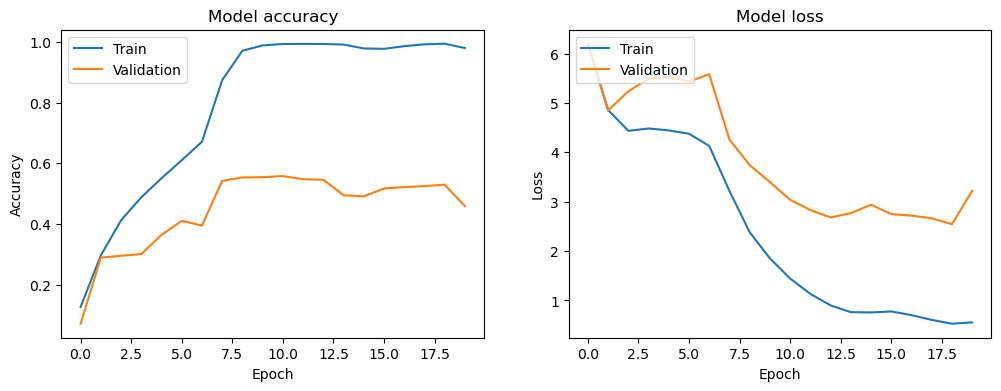

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 553ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:
                                precision    recall  f1-score   support

                          Boat       0.00      0.00      0.00        46
                   Bound_Angle       0.00      0.00      0.00        36
                           Bow       0.05      0.07      0.06        29
                        Bridge       0.00      0.00      0.00        27
                         Camel       0.07      0.06      0.06        35
                       Cat_Cow       0.02      0.02      0.02        47
                         Chair       0.00      0.00      0.00        36
                         Child       0.00      0.00      0.00        35
                         Cobra       0.02      0.02      0.02        93
                      Cockerel       0.00      0.00      0.00        20
                        Corpse       0.00      0.00      0.00        30
                      Cow_Face       0.04      0.06      0.05        34
                          Crow       0.0

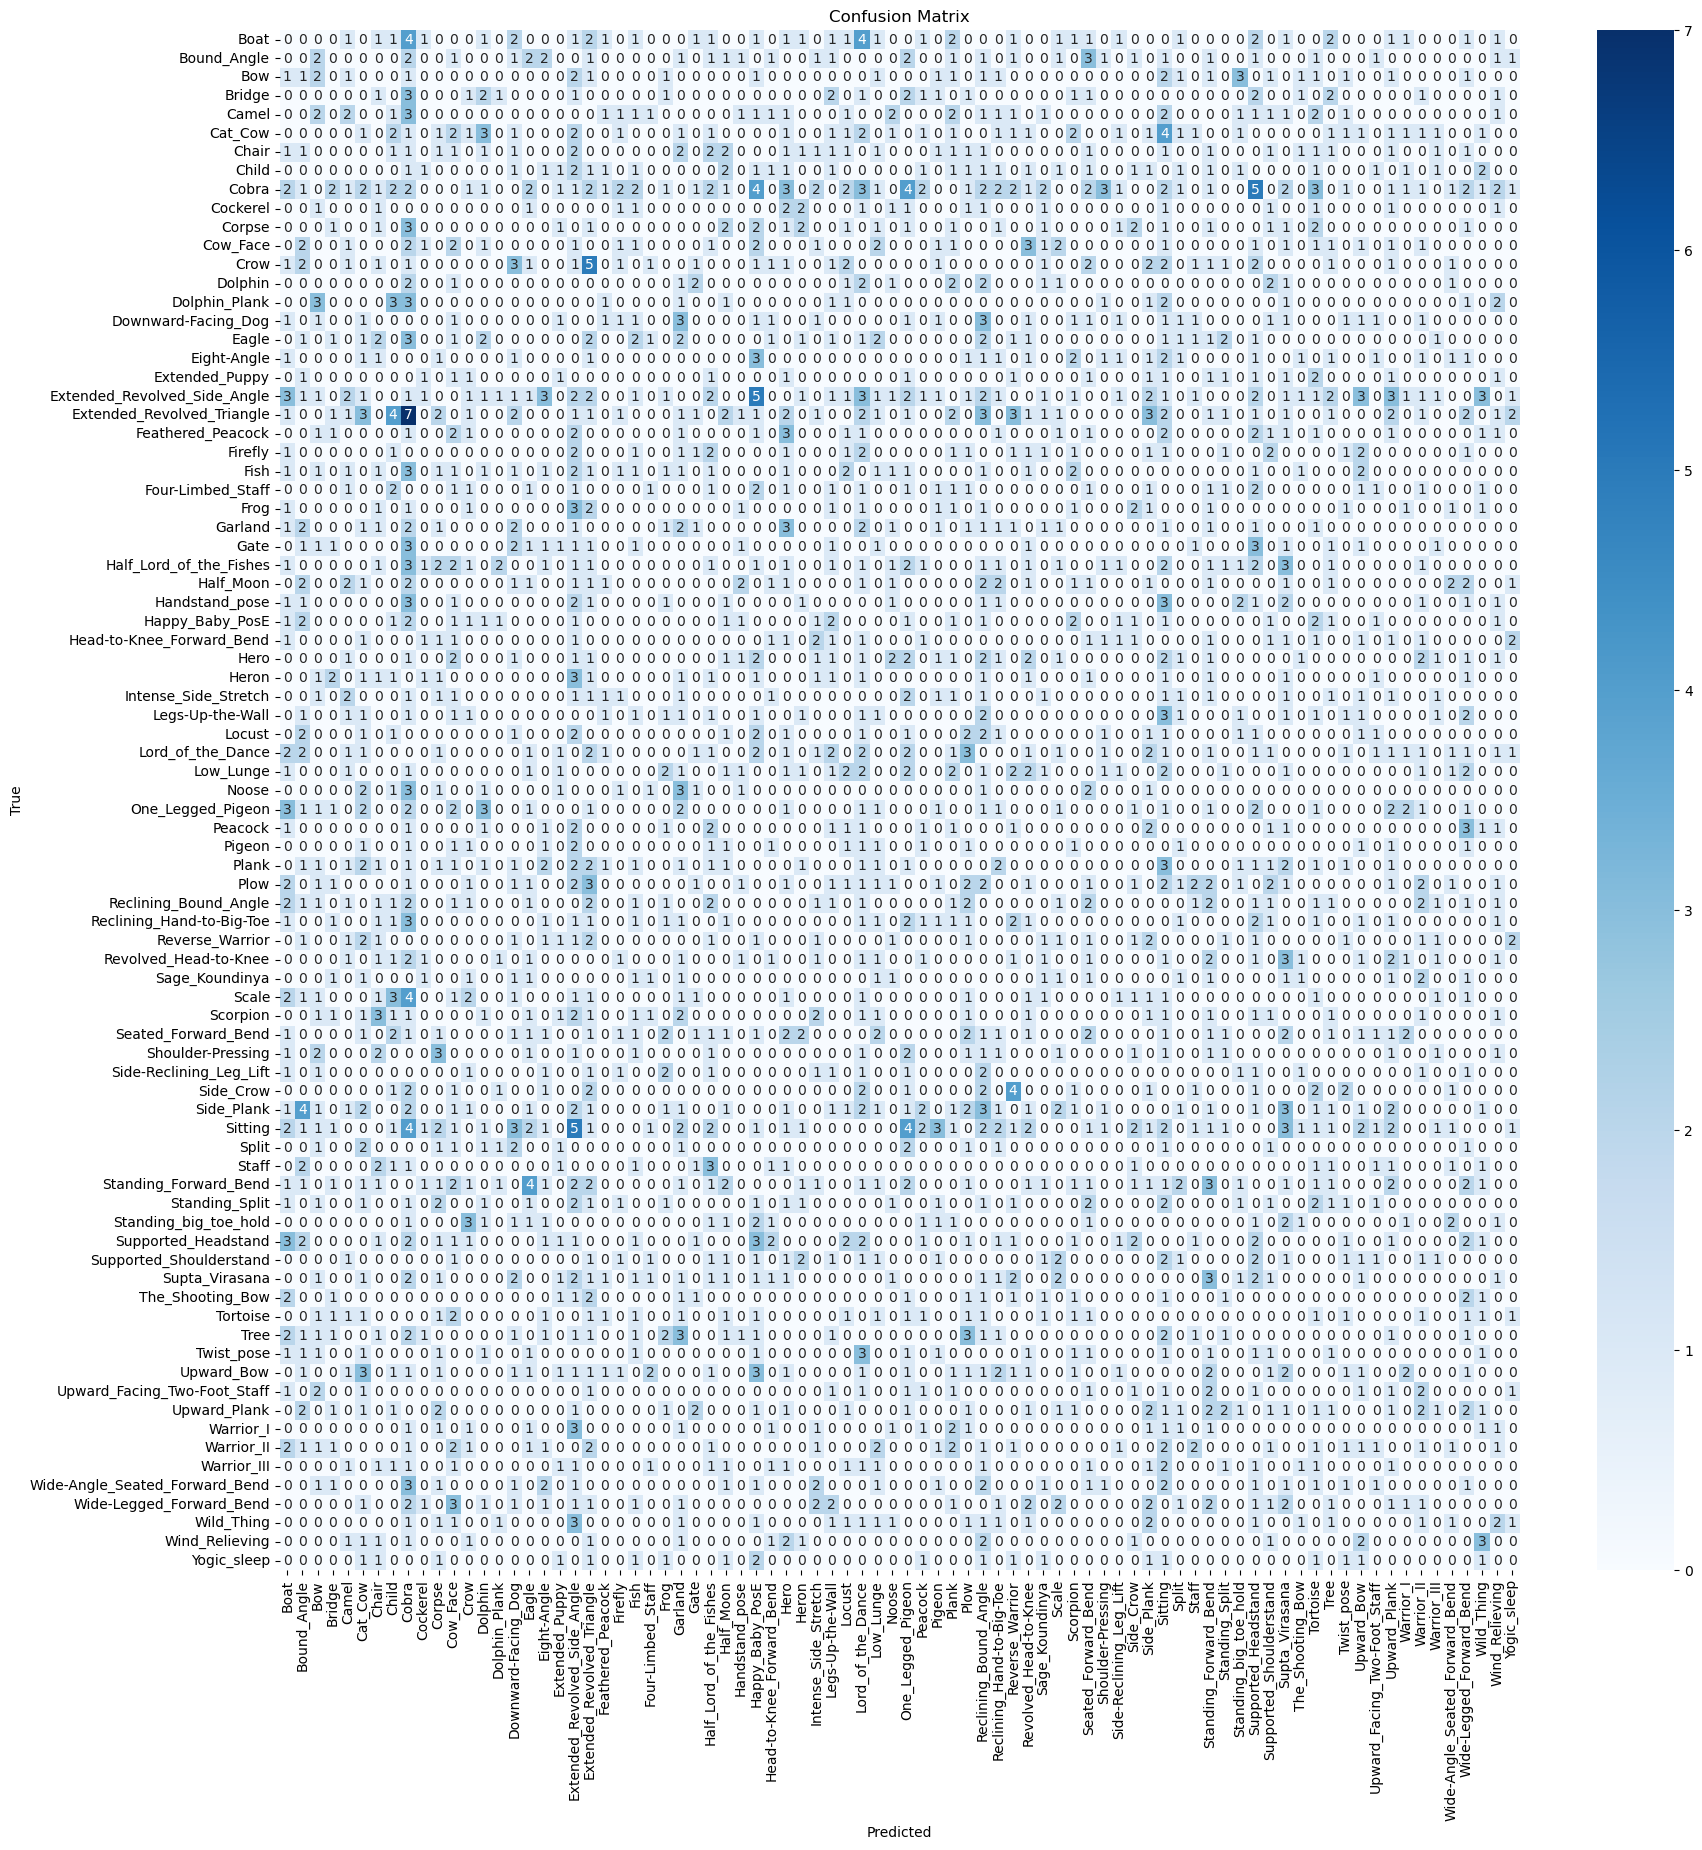

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()